In [1]:
import os
import pandas as pd 
import numpy as np
import warnings

import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.backends.backend_pdf import PdfPages

from neuron_morphology.swc_io import morphology_from_swc
from morph_utils.visuals import basic_morph_plot
from morph_utils.measurements import leftextent, rightextent 
from morph_utils.modifications import normalize_position

import sys 
sys.path.append(r'..\utils') 
from utils import get_seaad_colors, add_swc_paths


In [2]:
#human
# h_class_col =     'GA_RSC122-365_class_Corr'
# h_subclass_col =  'GA_RSC122-365_subclass_Corr'
# h_cluster_col =   'GA_RSC122-365_cluster_Corr'

h_class_col =     'GA_RSC-122-380_class_Corr_label'
h_subclass_col =  'GA_RSC-122-380_subclass_Corr_label'
h_cluster_col =   'GA_RSC-122-380_cluster_Corr_label'

#macaque
p_class_col =     'GA_RSC-204-380_class_Corr_label'
p_subclass_col =  'GA_RSC-204-380_subclass_Corr_label'
p_cluster_col =   'GA_RSC-204-380_cluster_Corr_label'

#rename to
class_col =     'GA_class'
subclass_col =  'GA_subclass'
cluster_col =   'GA_cluster'

In [3]:
viewer_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250529_seaad\macaque'
os.makedirs(viewer_dir, exist_ok=True)

viewer_type = 'dendrite' #dendrite, axon, both 

#HUMAN
human_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\Features\dendrite'
# human_metadata = pd.read_csv(os.path.join(human_data_root, 'metadata.csv'))
human_metadata = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\metadata\20250204\Datalock_11_6_24.csv', encoding='latin1')
human_raw_feature_wide = pd.read_csv(os.path.join(human_data_root, 'RawFeatureWide.csv'))
human_metadata = human_metadata.rename(columns={h_class_col: class_col, h_subclass_col: subclass_col, h_cluster_col: cluster_col, 'cell_id': 'specimen_id'})
human_metadata['species'] = 'human'
human_swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\SWC_Upright'

#MACAQUE
macaque_data_root = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\macaque\20250521'
macaque_metadata = pd.read_csv(os.path.join(macaque_data_root, 'macaque_species_compare.csv'))
macaque_raw_feature_wide = pd.read_csv(os.path.join(macaque_data_root, 'RawFeatureWide.csv'))
macaque_metadata = macaque_metadata[macaque_metadata.cell_specimen_id.isin(macaque_raw_feature_wide.specimen_id.tolist())]
macaque_metadata = macaque_metadata.rename(columns={p_class_col: class_col, p_subclass_col: subclass_col, p_cluster_col: cluster_col, 'cell_specimen_id': 'specimen_id'})
macaque_metadata['species'] = 'macaque'
macaque_swc_dir = r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\data\macaque\20250521\SWC_Upright'

#load swc paths

#combine data 
human_data = human_metadata[['specimen_id', subclass_col, cluster_col, 'species']].merge(human_raw_feature_wide, how='inner', on='specimen_id')
macaque_data = macaque_metadata[['specimen_id', subclass_col, cluster_col, 'species']].merge(macaque_raw_feature_wide, how='inner', on='specimen_id')

human_data = add_swc_paths(human_data, human_swc_dir, column_name='SWC_layer_aligned')
macaque_data = add_swc_paths(macaque_data, macaque_swc_dir, column_name='SWC_layer_aligned')

data = pd.concat([human_data, macaque_data])

feature_sort = 'soma_aligned_dist_from_pia'
viewer_outfile = os.path.join(viewer_dir, f'human_macaque_page_viewer_{viewer_type}_byTtypeGA_bySomaDepth_upright_depth_matched.pdf')

# node types to plot i.e. [soma, axon, basal, apical] 
if viewer_type == 'both': compartment_list=[1,2,3,4]
elif viewer_type == 'axon': compartment_list=[1,2]
elif viewer_type == 'dendrite': compartment_list=[1,3,4] 

cluster_var_name = 'GA_cluster'
sort_by = [cluster_var_name, 'species', feature_sort] 
plot_view = 'xy' #'xy', 'yz', or 'both'
num_rows = 7


title = ['specimen_id', 'species'] 
title_font_size = [2, 3]


Organize

In [4]:
# Load data
cells = data[['specimen_id', 'GA_cluster', 'species', 'soma_aligned_dist_from_pia', 'SWC_layer_aligned']]
cells = cells[~cells['GA_cluster'].isna()]
cells['specimen_id'] = cells['specimen_id'].astype(int)

# Set some vars
cluster_var = sort_by[0]

if plot_view == 'yz': set_side = [True]
elif plot_view == 'both': set_side = [False, True]
else: set_side = [False] #xy or other

#get plotting color dict
color_dict = get_seaad_colors()

# Sort cells 
if all(item in list(cells.columns) for item in sort_by): #check if all items in sort_by are column names in cells 
    sorted_cells = cells.sort_values(by=sort_by)
else:
    print('Warning: cannot sort cells. Some value(s) in \'sort_by\' are not column names in input cell csv. Plotting unsorted cells.')
    sorted_cells = cells


Select just the depth matched cells

In [5]:
soma_depth_df = pd.read_csv(r'\\allen\programs\celltypes\workgroups\mousecelltypes\SarahWB\datasets\human_exc\analysis\20250529_seaad\macaque\data_depth_matched.csv')
sorted_cells = sorted_cells[sorted_cells.specimen_id.isin(soma_depth_df.specimen_id)]

Plot

Sps list is 23 long


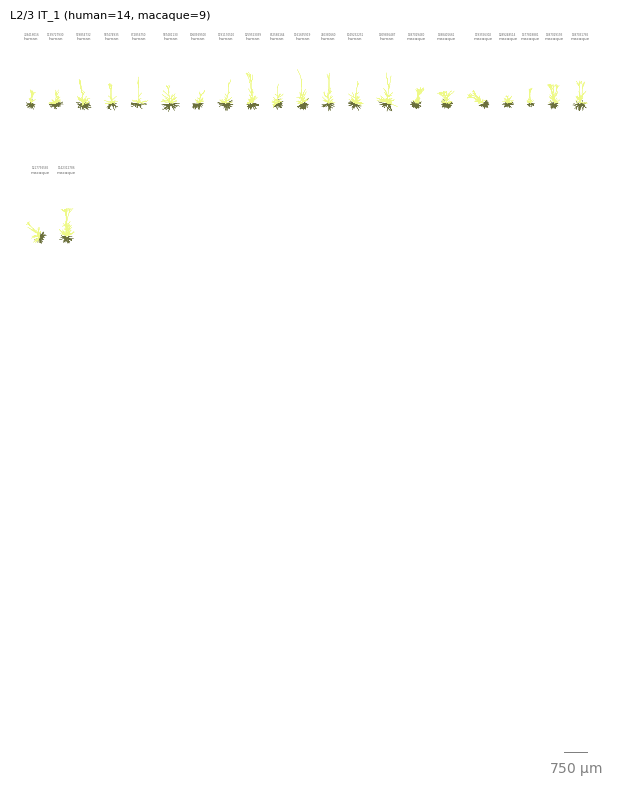

<Figure size 640x480 with 0 Axes>

In [6]:
#make pdf viewer

#formatting vars for tinkering 
group_title_start_height = 2700 #900 #starting height for group (e.g., region) title 
group_title_font_size = 8 #font size for group (e.g., region) title 

cell_title_start_height = 2300 #700 #starting height for cell title 
cell_title_vertical_space = 150 #150 #how much white space between rows of the cell title
cell_title_view_font_size = 4 #font size for cell 'xy', 'yz' view label

line_w = 0.1

#####

with warnings.catch_warnings():
    warnings.simplefilter(action='ignore', category=FutureWarning)

    sps_list = list(sorted_cells.specimen_id.values)
    sps_list.reverse() #because we pop() off spc, which takes off the last value in the list. Reversing here keeps the plotting order consistent with the csv order.

    clust_id_set = set()
    failed_to_load = []

    print("Sps list is {} long".format(len(sps_list)))
    buffer=400
    with PdfPages(viewer_outfile) as pdf:
        while sps_list != []:
            fig, axes = plt.subplots(nrows=6,ncols=1,figsize=(7.5,10),sharex=True,sharey=True, gridspec_kw = {'wspace':0, 'hspace':0.3}) 
            for ax in axes: 

                ax.axis('off')
                ax.set_xlim(0,18100) 
                lim = 18000
                xloc = 0
                xoffset = 0
                ax.set_anchor('W')
                # ax.axhline(0, c="lightgrey",linewidth=0.50)

                while xloc < lim: #plot as many neurons as fit on this row
                    if sps_list != []:
                        sp = sps_list.pop() 
                        
                        # get data for this specimen
                        # subclass = sorted_cells[sorted_cells.specimen_id==sp][subclass_var_name].iloc[0]
                        clust_id = sorted_cells[sorted_cells.specimen_id==sp][cluster_var].iloc[0]
                        clust_len = len(sorted_cells[sorted_cells[cluster_var]==clust_id])

                        # cell title
                        sp_title = []
                        if 'title' in locals():
                            for t in title:
                                sp_title.append(str(sorted_cells[sorted_cells.specimen_id==sp][t].iloc[0]))
                        
                        # get plotting colors 
                        try:
                            # decide the colors for this cells axon, apical, and basal
                            hex_color = color_dict[clust_id][1:]

                            contrast_level = 0.45
                            lighter_color_rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
                            darker_color_rgb = tuple([int((contrast_level*x)) for x in lighter_color_rgb])
                            grey_hex = '#8f8f8f'
                            dark_hex = '#%02x%02x%02x' % darker_color_rgb
                            hex_color = '#'+hex_color

                            cell_type_colors_dict = {3: dark_hex, 4: hex_color, 2: grey_hex}

                            #swap colors for axon-only plotting
                            if compartment_list == [1,2]: 
                                cell_type_colors_dict = {3: grey_hex, 4: grey_hex, 2: hex_color}
                        except: 
                            cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                        morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}


                        # cell_type_colors_dict={1: 'black', 2: "firebrick", 4: "orange", 3: "steelblue"}
                        # morph_colors = {k:v for k,v in cell_type_colors_dict.items() if k in compartment_list}
                        
                        # get the layer-aligned file
                        swc_pth = sorted_cells.SWC_layer_aligned[sorted_cells.specimen_id == sp].iloc[0]
                        nrn = morphology_from_swc(swc_pth)
                        nrn = normalize_position(nrn)

                        xoffset += leftextent(nrn,compartment_list)
                        if clust_id not in clust_id_set:
                            if xloc != 0:
                                sps_list = sps_list + [sp]
                                break

                            else:
                                #plot cell title
                                y = cell_title_start_height
                                i = 0
                                for l in sp_title:
                                    y-=cell_title_vertical_space
                                    ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                                    i+=1
                                    
                                #plot cell cluster info (e.g. ttype and num cells)
                                n_human = len(sorted_cells[(sorted_cells[cluster_var] == clust_id) & (sorted_cells['species'] == 'human')])
                                n_nhp = len(sorted_cells[(sorted_cells[cluster_var] == clust_id) & (sorted_cells['species'] == 'macaque')])
                                ax.text(-500,group_title_start_height, f"{clust_id} (human={n_human}, macaque={n_nhp})",
                                horizontalalignment='left',fontsize=group_title_font_size, color='black') 

                                clust_id_set.add(clust_id)

                                y-=cell_title_vertical_space
                                for s in set_side:
                                    basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s, line_w=line_w, 
                                                     scatter_roots = False, scatter_soma = False, plot_soma = False)
                                    xoffset += rightextent(nrn,compartment_list)
                                    xoffset += buffer       

                        else:
                            if xoffset+rightextent(nrn,compartment_list)+buffer>lim: #if gone over page width limit for this row, pop cell back on list and go to next plotting row
                                sps_list = sps_list + [sp]
                                break
                            else:
                                
                                clust_id_set.add(clust_id)
                                y = cell_title_start_height #plot cell title 
                                i = 0
                                for l in sp_title:
                                    y-=cell_title_vertical_space
                                    ax.text(xoffset, y,l,horizontalalignment='center',fontsize=title_font_size[i], color="dimgrey")
                                    i+=1

                                y-=cell_title_vertical_space
                                for s in set_side:
                                    basic_morph_plot(nrn, morph_colors = morph_colors, ax = ax, xoffset = xoffset, side = s, line_w=line_w, 
                                                     scatter_roots = False, scatter_soma = False, plot_soma = False)
                                    xoffset += rightextent(nrn,compartment_list)
                                    xoffset += buffer                            

                        xloc=xoffset

                    else:
                        break

            #add a scale bar 
            scalebar = ScaleBar(1, "um", location='lower right', frameon=False, length_fraction=0.05, color='grey')
            ax.add_artist(scalebar)

            for ax in axes:
                ax.set_aspect("equal")
            fig.subplots_adjust(wspace=0, hspace=0.0)
            pdf.savefig(dpi=600)
    plt.show()
    plt.clf()
    print()


In [7]:
#the end 
